# Holo2: Cookbook

[![Colab](https://img.shields.io/badge/Open_in_Colab-F9AB00?logo=googlecolab&logoColor=fff&style=for-the-badge)](https://colab.research.google.com/github/hcompai/hai-cookbook/blob/main/holo2)
[![GitHub](https://img.shields.io/badge/Holo_Cookbooks-100000?style=for-the-badge&logo=github&logoColor=white)](https://github.com/hcompai/hai-cookbook)
[![Hugging Face](https://img.shields.io/badge/H_Company-FFD21E?style=for-the-badge&logo=huggingface&logoColor=000)](https://huggingface.co/Hcompany)

Holo2 is a **state-of-the-art Action Vision-Language Model** developed by [H Company](https://www.hcompany.ai/). Fine-tuned from the [Qwen3-VL Thinking Family](https://huggingface.co/collections/Qwen/qwen3-vl), it excels at **UI element localization** and **UI navigation** across environments (computer, web, mobile).

This quickstart demonstrates the core grounding capability: **(screenshot + task) → click coordinates**.

## Setup

First, let's import the required dependencies. This cookbook was tested on Python>=3.11.

In [ ]:
!pip install -q -U accelerate matplotlib pillow pydantic requests torchvision transformers

In [ ]:
from typing import Any, Literal, TypeAlias

import requests
import torch
from PIL import Image
from pydantic import BaseModel, Field
from transformers import AutoModelForImageTextToText, AutoProcessor
from transformers.models.qwen2_vl.image_processing_qwen2_vl import smart_resize

#

## 1. Load model and processor

Our Holo2 family of VLMs includes three model sizes to cover hardware requirements for deployment: 4B, 8B and an 30B-A3B MoE.

Model cards for the Holo2 family:

[![Hugging Face](https://img.shields.io/badge/Holo_2_4B-FFD21E?style=for-the-badge&logo=huggingface&logoColor=000)](https://huggingface.co/Hcompany/Holo2-4B)
[![Hugging Face](https://img.shields.io/badge/Holo_2_8B-FFD21E?style=for-the-badge&logo=huggingface&logoColor=000)](https://huggingface.co/Hcompany/Holo2-8B)
[![Hugging Face](https://img.shields.io/badge/Holo_2_30B--A3B-FFD21E?style=for-the-badge&logo=huggingface&logoColor=000)](https://huggingface.co/Hcompany/Holo2-30B-A3B)

In [ ]:
model_name = "Hcompany/Holo2-4B"  # or "Hcompany/Holo2-8B", "Hcompany/Holo2-30B-A3B"

# Load model and processor
model = AutoModelForImageTextToText.from_pretrained(
    model_name,
    dtype=torch.bfloat16,
    device_map="auto",
)
processor = AutoProcessor.from_pretrained(model_name)

Loading checkpoint shards: 100%|██████████| 4/4 [00:01<00:00,  3.54it/s]


## 2. Define Actions and System Prompt

## How It Works

The model uses structured output to return precise navigation actions. In the cookbook, we only demonstrate the localization capability of our model for simplicity.

In [ ]:
class ClickCoordinates(BaseModel):
    x: int = Field(ge=0, le=1000, description="The x coordinate, normalized between 0 and 1000.")
    y: int = Field(ge=0, le=1000, description="The y coordinate, normalized between 0 and 1000.")

ChatMessage: TypeAlias = dict[str, Any]


def get_chat_messages(task: str, image: Image.Image) -> list[ChatMessage]:
    """Create the prompt structure for navigation task"""
    prompt = f"""Localize an element on the GUI image according to the provided target and output a click position.
     * You must output a valid JSON following the format: {ClickCoordinates.model_json_schema()}
     Your target is:"""

    return [
        {
            "role": "user",
            "content": [
                {"type": "image", "image": image},
                {"type": "text", "text": f"{prompt}\n{task}"},
            ],
        },
    ]

Now let's download a sample screenshot and define our navigation task.

## 3. Download Image

Task: Book a hotel in Paris on August 3rd for 3 nights


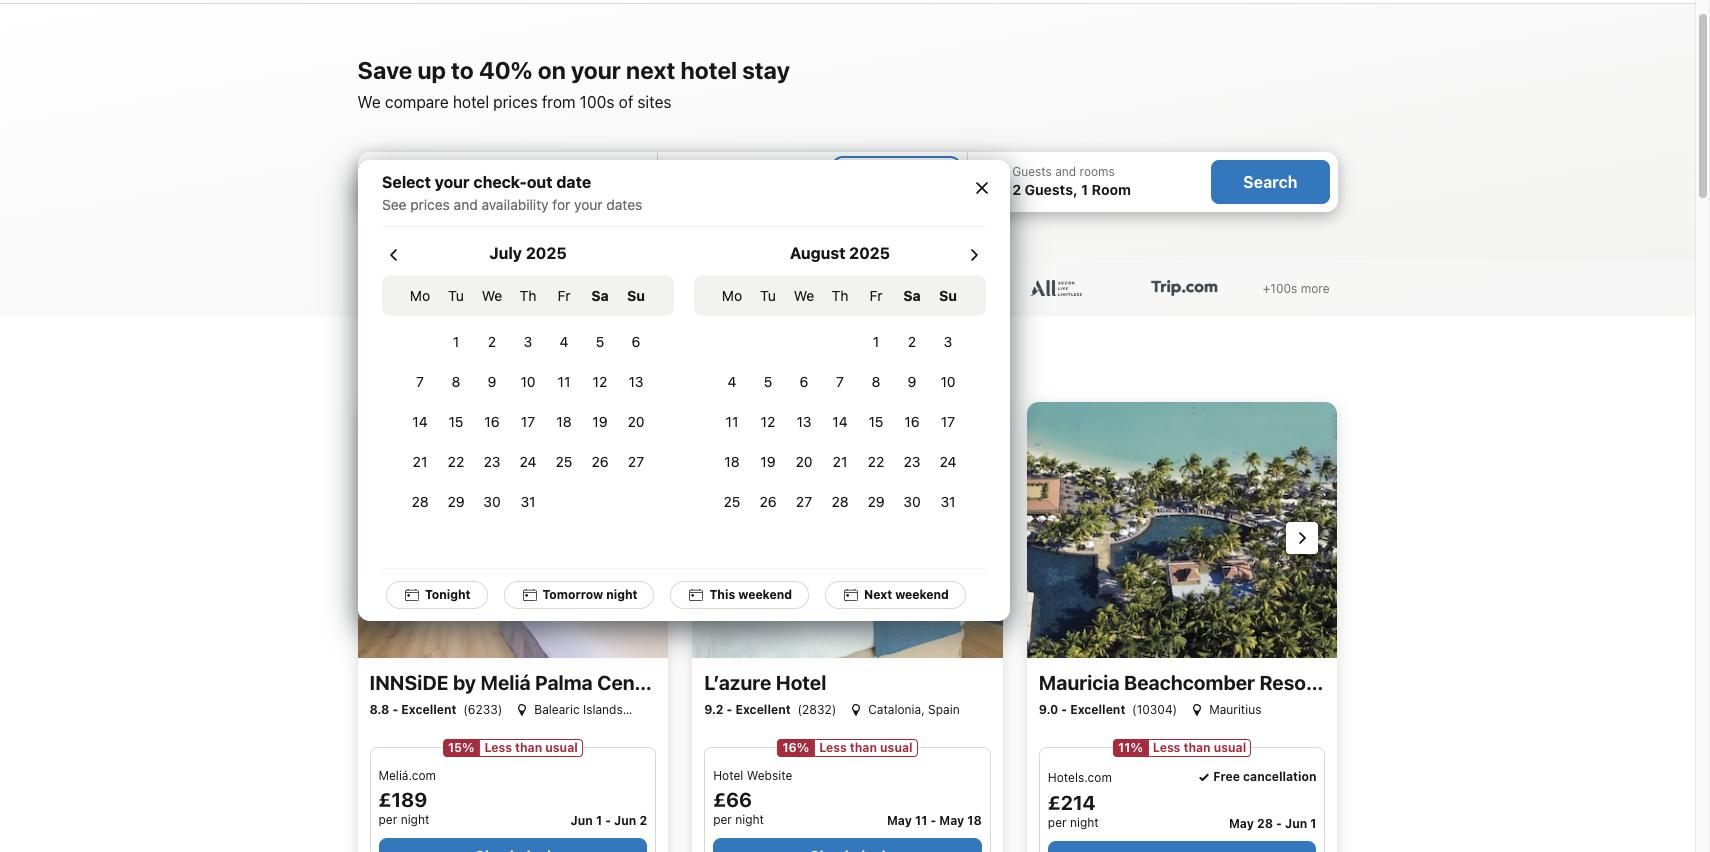

In [40]:
# Example image URL for a web screenshot (replace with your own image)
image_url: str = "https://raw.githubusercontent.com/hcompai/hai-cookbook/445d2017fcc8a0867081ea4786c34f87ed7053eb/data/calendar_example.jpg"

# Download and open image
response = requests.get(image_url, stream=True)
image = Image.open(response.raw)

# Define task
task: str = "Book a hotel in Paris on August 3rd for 3 nights"

print(f"Task: {task}")
image.show()

## 4. Set Task and Prepare Image

In [ ]:
# Resize image according to model's image processor
image_processor_config = processor.image_processor
resized_height, resized_width = smart_resize(
    image.height,
    image.width,
    factor=image_processor_config.patch_size * image_processor_config.merge_size,
    min_pixels=image_processor_config.size.get("shortest_edge", None),
    max_pixels=image_processor_config.size.get("longest_edge", None),
)

processed_image: Image.Image = image.resize(size=(resized_width, resized_height), resample=Image.Resampling.LANCZOS)

# Create the prompt
messages: list[dict[str, Any]] = get_chat_messages(task, processed_image)

# Apply chat template
# Note - For localization we set thinking to False
text_prompt = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True, thinking=False)

# Process inputs
inputs = processor(
    text=[text_prompt],
    images=[processed_image],
    padding=True,
    return_tensors="pt",
).to(model.device)

## 5. Run Inference

Because structured output is not enabled and generation is stochastic, parsing the output might fail. Thus, in production settings, we recommend using [vLLM](https://github.com/vllm-project/vllm) for:

- Faster inference performance
- Built-in structured output validation
- Reliable JSON schema compliance.

In [49]:
# Generate response
generated_ids = model.generate(**inputs, max_new_tokens=32)

def parse_reasoning(generated_ids:torch.tensor)->tuple[torch.tensor,torch.tensor]:
    """Parse content from generated_ids"""
    all_ids = generated_ids[0].tolist()
    think_start_index = all_ids.index(151667)
    try:
        think_end_index = all_ids.index(151668)
    except:
        think_end_index = len(all_ids)

    thinking_content = processor.decode(all_ids[think_start_index+1:think_end_index], skip_special_tokens=True).strip("\n")
    content = processor.decode(all_ids[think_end_index+1:], skip_special_tokens=True).strip("\n")

    return content, thinking_content

content, thinking_content = parse_reasoning(generated_ids)

print("Content:", content)
print("Thinking:", thinking_content)

Content: {"x":552,"y":404}
Thinking: 


In [43]:
action = ClickCoordinates.model_validate_json(content)
print("action:", action)


action: x=555 y=405


## 6. Visualize Results

Predicted action: Click on 'Book a hotel in Paris on August 3rd for 3 nights' at coordinates (941.2800000000001, 349.92)


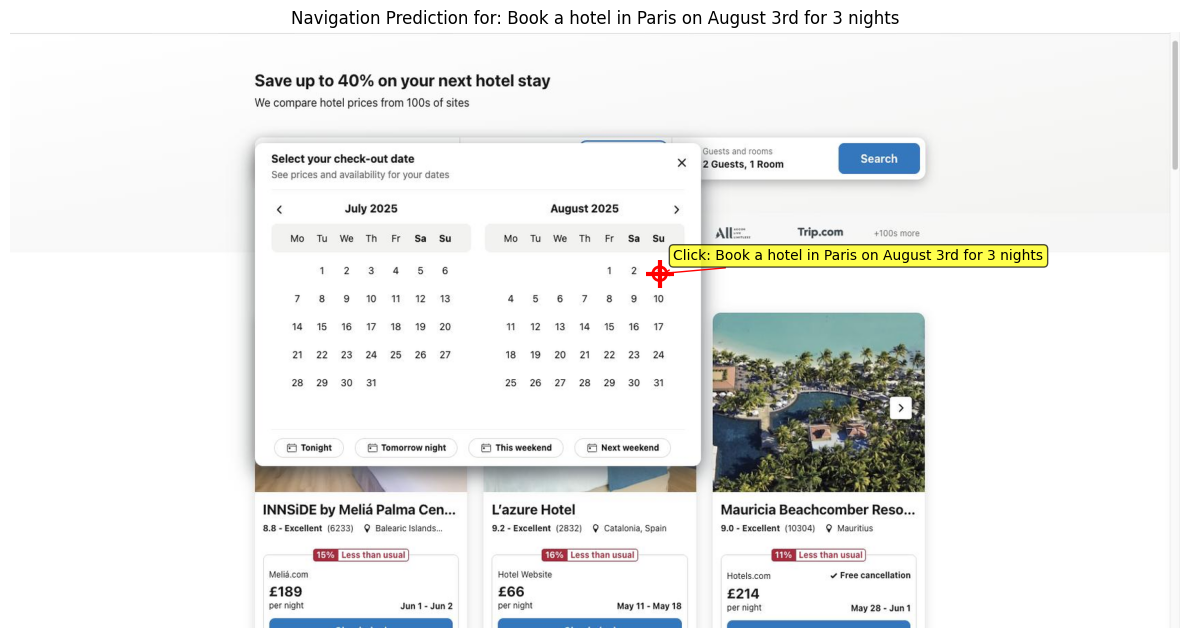

In [44]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.figure import Figure
from matplotlib.axes import Axes


def visualize_click(action: ClickCoordinates, processed_img: Image.Image, task: str = "") -> tuple[Figure, Axes]:
    """
    Visualize the navigation prediction on the image.

    Args:
        navigation_output: The parsed navigation step with action coordinates
        processed_img: The processed PIL image
        task: The task description for the title

    Returns:
        Tuple of matplotlib Figure and Axes objects
    """
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    ax.imshow(processed_img)

    x = action.x / 1000 * processed_img.width
    y = action.y / 1000 * processed_img.height

    print(f"Predicted action: Click on '{task}' at coordinates ({x}, {y})")

    # Plot red cross at predicted coordinates
    ax.plot(x, y, "r+", markersize=20, markeredgewidth=3)

    # Add a circle around the cross for better visibility
    circle = patches.Circle((x, y), 10, linewidth=2, edgecolor="red", facecolor="none")
    ax.add_patch(circle)

    # Add text annotation
    if task:
        ax.annotate(
            f"Click: {task}",
            xy=(x, y),
            xytext=(x + 20, y - 20),
            arrowprops=dict(arrowstyle="->", color="red"),
            bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7),
            fontsize=10,
        )

    ax.set_title(f"Navigation Prediction for: {task}")
    ax.axis("off")
    plt.tight_layout()

    return fig, ax

fig, ax = visualize_click(action, processed_image, task=task)
plt.show()

The visualization shows:
- **Red cross (⊕)**: Exact pixel coordinates where the model wants to click
- **Red circle**: Visual boundary around the target area
- **Yellow annotation**: Description of what element the model identified

The model correctly identified "August 3rd on the calendar" at coordinates (947, 338), demonstrating precise localization within the complex calendar interface.